In [105]:
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using ForneyLab
using NARMAX
import ProgressMeter
using CSV
using DataFrames
using Statistics

In [106]:
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision

In [107]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [108]:
function model_specification(ϕ; M1=M1, M2=M2, M3=M3, N=N)

    graph = FactorGraph()

    # Observed variables
    @RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
    @RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
    @RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
    @RV u_k; placeholder(u_k, :u_k)

    # Time-invariant parameters
    @RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
    @RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N,N)))

    # Likelihood
    @RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
    placeholder(y_k, :y_k)

    q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
    algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
    return algorithmSourceCode(algorithm, free_energy=true)
    
end

model_specification (generic function with 1 method)

In [109]:
function experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ, priors; M1=1, M2=1, M3=1, N=3, num_iters=5, computeFE=false)

    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    "Inference execution"

    # Extract prior parameters
    θ_k = priors["θ"]
    τ_k = priors["τ"]

    # Initialize marginals
    marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                     :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

    # Preallocate free energy array
    Fq = zeros(T_trn-maxM, num_iters)

    # Preallocate parameter arrays
    params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
    params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

    # Preallocate prediction arrays
    predictions = (zeros(T_trn,), zeros(T_trn,))
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)
        
        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

        # Compute prediction error
        errors[k] = output_trn[k] - predictions[1][k]
        
        # Set data 
        data = Dict(:y_k => output_trn[k],
                    :u_k => input_trn[k],
                    :u_kmin1 => u_kmin1,
                    :y_kmin1 => y_kmin1,
                    :e_kmin1 => e_kmin1,
                    :m_θ => θ_k[1],
                    :w_θ => θ_k[2],
                    :a_τ => τ_k[1],
                    :b_τ => τ_k[2])
        
        # Iterate updates
        for n = 1:num_iters
            
            # Compute free energy
            if computeFE
                Fq[ii,n] = freeEnergy(data,marginals)
            end
            
            # Update parameters
            stepθ!(data, marginals)
            stepτ!(data, marginals)
            
        end 
        
        # Update params
        θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
        τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
        
        # Store params
        params_θ[1][ii,:] = θ_k[1]
        params_θ[2][ii,:,:] = θ_k[2]
        params_τ[1][ii] = τ_k[1]
        params_τ[2][ii] = τ_k[2]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = (zeros(T_tst,), zeros(T_tst,))
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

        # Update error
        errors[k] = output_tst[k] - predictions[1][k]
        
    end

    "Simulation"

    # Prepare array
    simulations = (zeros(T_tst,), zeros(T_tst,))

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[1][k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[1][k] = θ_k[1]'*ϕx
        # simulations[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[1][maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

    if computeFE
        return RMS_sim, RMS_prd, Fq
    else
        return RMS_sim, RMS_prd, simulations, predictions, θ_k[1]
    end
end

experiment_FEM (generic function with 1 method)

In [110]:
function experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ; M1=1, M2=1, M3=1, N=1, λ=1.00)
    
    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    # Parameters
    P = λ.*Matrix{Float64}(I,N,N)
    w_k = zeros(N,)

    # Preallocate prediction array
    predictions = zeros(T_trn,)
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)

        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        # Update data vector
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        
        # Update weights
        α = output_trn[k] - w_k'*ϕx 
        g = P*ϕx*inv(λ + ϕx'*P*ϕx)
        P = inv(λ)*P - g*ϕx'*inv(λ)*P
        w_k = w_k + α*g
        
        # Prediction
        predictions[k] = w_k'*ϕx
        errors[k] = output_trn[k] - predictions[k]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = zeros(T_tst,)
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[k] = w_k'*ϕx

        # Update error
        errors[k] = output_tst[k] - predictions[k]
        
    end

    "Simulation"

    # Prepare array
    simulations = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[k] = w_k'*ϕx
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[maxM+1:end] - output_tst[maxM+1:end]).^2))

    return RMS_sim, RMS_prd, simulations, predictions, w_k
end

experiment_RLS (generic function with 1 method)

In [111]:

df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"))[1:1000, :];
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

output_trn = y_train
output_val = y_val
input_trn = input_trn
input_val = input_val

1000-element Vector{Float64}:
 -1.8033614940326523
 -1.7805795086575766
 -1.762775515742824
 -1.7483264720210125
 -1.734669156722314
 -1.718042859836942
 -1.6945879053022206
 -1.6600487528439178
 -1.6111595227166924
 -1.5451491654396496
 -1.4607311223252304
 -1.357806427320546
 -1.2378595712189326
  ⋮
  0.5721305700701793
  0.6183477167693983
  0.655361020549929
  0.6838632437819954
  0.7041512846242651
  0.7166210072882941
  0.7210744796683047
  0.7170168714998506
  0.7033595562011523
  0.6785190769259831
  0.6405161126165613
  0.5870744440564364

In [112]:
# find order
M1, M2, M3 = 3, 3, 3
poly_order = 2
options = Dict("na"=>M1, "nb"=>M2, "ne"=>M3, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)

PΦ = gen_combs(options)
ϕ_fl(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)]
N = size(PΦ,2)

42

In [113]:
# Specify model and compile update functions
source_code = model_specification(ϕ_fl, M1=M1, M2=M2, M3=M3, N=N)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [114]:
# Initialize priors
priors = Dict("θ" => (zeros(N,), Matrix{Float64}(I,N,N)), 
              "τ" => (1.0, var(output_trn)))
prior_mτ = priors["τ"][1] ./ priors["τ"][2]  

0.2117549994436263

In [115]:
rms_sim, rms_pred, sim, pred, coefs = experiment_FEM(input_trn, output_trn, input_val, output_val, ϕ_fl, priors, M1=M1, M2=M2, M3=M3, N=N, num_iters=10, computeFE=false)

(NaN, 0.1729182802551352, ([0.0, 0.0, 0.0, 0.16654789518724467, 0.3456170483134839, 0.7353776246559915, 0.5025140848155628, 0.6411165292925568, 0.49848064253562885, 0.561449473268721  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ([0.0, 0.0, 0.0, 0.16654789518724467, 3.498612533924133, 6.262116119343088, 4.613709474349003, 4.854709633088752, 4.765781341642014, 4.951337731326848  …  2.4764443781089844, 2.52821464459685, 2.6088508035251508, 2.655732959591598, 2.7119683256333764, 2.721525432115936, 2.7781024138762107, 2.8554786867707307, 2.9421866135746915, 3.0123788191615715], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), [0.09682604893636435, -0.019595700201399665, 0.010572731778323713, -0.10537398877809737, -0.03900626708628222, 0.01450546864914462, 0.018371263138710577, -0.014394192118979382, 0.03729047581171657, 

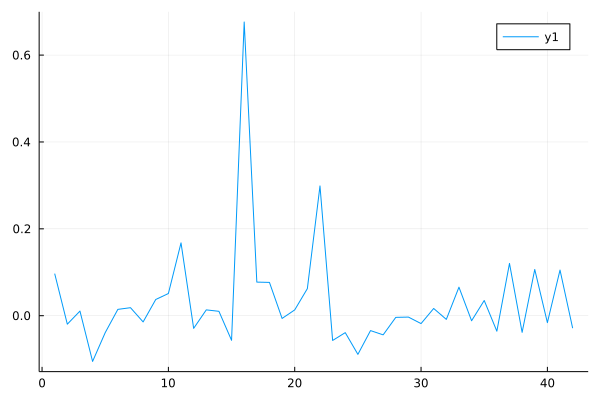

In [116]:
plot(coefs)

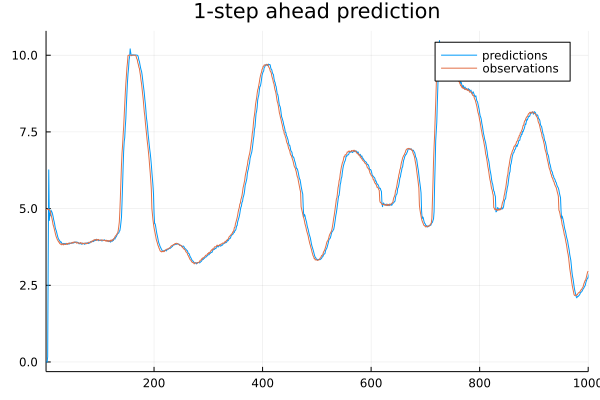

In [120]:
plot(pred[1], label="predictions")
plot!(output_val, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

In [99]:
rms_sim, rms_pred, sim, pred, coefs = experiment_RLS(input_trn, output_trn, input_val, output_val, ϕ_fl, M1=M1, M2=M2, M3=M3, N=N, λ=1.0)

(NaN, 0.20273122565801988, [0.0, 0.0, 0.0, -0.5791673231939232, -0.7815800723724294, -0.6227126276802843, -0.9225961320940796, -0.8741434156574335, -1.0932605721718707, -1.0971628858405227  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [0.0, 0.0, 0.0, -0.5791673231939232, 2.3573907408987207, 5.154990758631648, 4.726578475390208, 4.994902663082121, 4.874851025919582, 4.900735572859199  …  2.4737273786500102, 2.523522200819614, 2.601496146662581, 2.6420188522191523, 2.695079422537389, 2.6964748736754336, 2.7525375457271175, 2.825192325871463, 2.9066090803534244, 2.9681316656771712], [0.9279263290509219, 0.3364641376862697, -0.7322101952147472, -0.3255753064177514, -0.08418860333637647, -0.27587403137897576, -0.12795685723463804, 0.044378352801199596, 0.10292870444608196, 0.16150372019095935  …  0.08491340922478267, 0.023482398830116196, 0.027196992217768827, -0.051265641607347444, 0.204916761491204, -0.028988954047479885, 0.12680444988448678, -0.022234883789707834, 0.120716629109

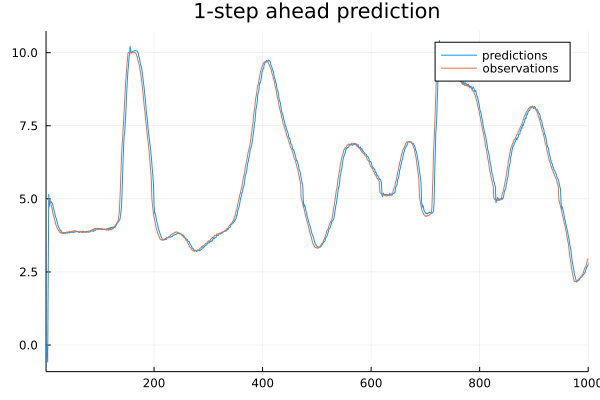

In [84]:
plot(pred, label="predictions")
plot!(output_val, xlims=(1, 1000), title="1-step ahead prediction", label="observations")